# ENSF 519.01 Applied Data Science 
### Satyaki Ghosh, 10077685
**Assignment 5** - 100 marks

**Due:** November 25, 05.00 pm.


**IMPORTANT NOTE: each task must be implemented as asked, even if there are other easier or better solutions.**

**How to deliver:**
Edit this file and write your solutions in sections specified with `# Your solution`. Test your code and when you are done, submit this notebook as an `.ipynb` file to D2L dropbox. 



## Spam detection 

Here we have a dataset of text messages which are labeled as spam or ham. We want to read the dataset and use a clustering algorithm to tell spam messages from non-spam (ham!) ones. The data is in tsv format with two columns: label and text. TSV is just like csv but the column values are separated by a tab instead of a `,`. 

1. Read the file into a dataframe
2. Convert `label` column to pandas categorical data type
3. complete the `clean_text` function and apply it to the text column. To clean up:
    1. Make it lowercase
    2. Remove all of the punctuations (use `string.punctuation` and `str.translate`)
    3. Replace repetetive whitespaces with just one blank charachter (e.g.: 'i    had \tan apple' -> 'i had an apple')
    4. Removing the stop words
    5. Stem each word using snowball stemmer provided in `nltk`


In [1]:
import re, string
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt 
%matplotlib inline


stemmer = SnowballStemmer('english')
def clean_text(text):
    """
    text: str, returns: str
    """
    # Your solution
    text = text.strip().lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = list(filter(lambda word: word not in ENGLISH_STOP_WORDS, words))
    stemmed = [stemmer.stem(word) for word in words]

    return ' '.join(stemmed)


sms = pd.read_csv('sms.tsv', sep='\t', names=['label', 'text'])
# Your solution
sms['label'] = sms.label.astype('category')
sms['text'] = sms['text'].apply(clean_text)
print(sms.dtypes)  # Expected: label category text object dtype: object
sms

label    category
text       object
dtype: object


,label,text
0,ham,jurong point crazi avail bugi n great world la...
1,ham,ok lar joke wif u oni
2,spam,free entri 2 wkli comp win fa cup final tkts 2...
3,ham,u dun say earli hor u c say
4,ham,nah dont think goe usf live
...,...,...
5567,spam,2nd time tri 2 contact u u won £750 pound priz...
5568,ham,ü b go esplanad fr home
5569,ham,piti mood soani suggest
5570,ham,guy did bitch act like id interest buy week ga...


Split the data into train and test sets (20% test 80% training), use `stratify` parameter to ensure that there is an even split for both categories. X values should be the vectors and y values the labels.


Complete `build_tfidf` function below to make and fit a TF-IDF vectorizer with `min_df` = 2. This function is later called in the loop. 

Similar to previous assignments and problems, change the random state in a for loop from 0 to 9, in each iteration:

1. The vectorizer instance is created on the training set. Convert the `X_train` and `X_test` by calling the `transform` method. You don't have to refit the transformer in the loop.
2. train and evaluate these classifiers: 

    * LogisticRegression 
    * LinearSVC
    * Naïve Bayes, with Bernoulli distribution
    * Decision tree, use 20 for `min_samples_split` to prevent overfitting
    * Random Forest, with a 100 estimators and use min_samples_split like above

 

Use `random_state`s from in `[0, 5)` in classifier contruction for those which accept this parameter.
Keep record of these scores in a pandas dataframe and make a boxplot to compare them. Set ylim to `(0.85, 1)`. 

**You should do all these inside the `fit_eval` and `build_tfidf` functions. Don't add any lines of code before or after it.** Also it doesn't need to return any values.

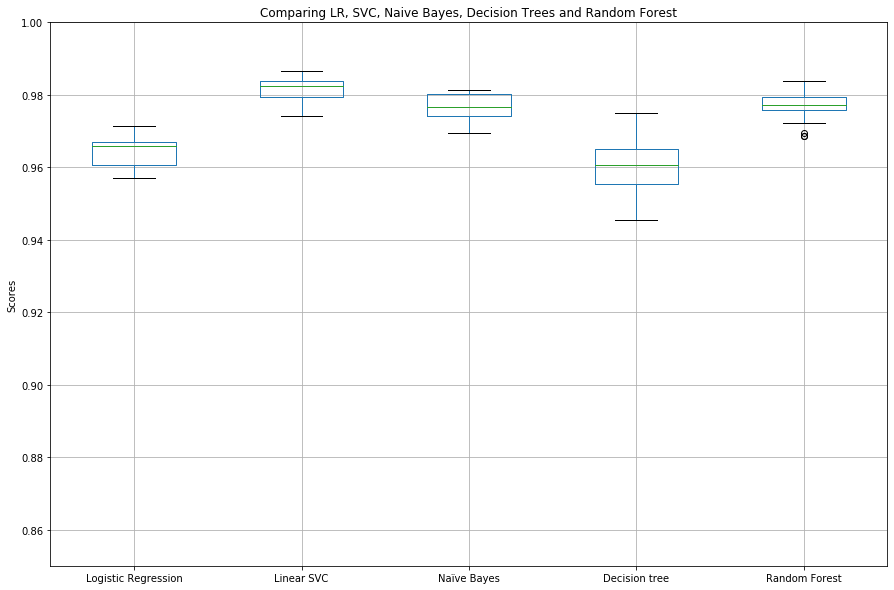

In [2]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

def build_tfidf(X_train):
    vectorizer = TfidfVectorizer(min_df=2)  # Your solution
    # Fit the vectorizer here
    vectorizer.fit(X_train)
    return (vectorizer,)  # A tuple with only one item


def fit_eval(get_vectorizer):
    # Column names: 'Logistic Regression', 'Linear SVC', 'Naïve Bayes', 'Decision tree', 'Random Forest'
    scores = {name: [] for name in ('Logistic Regression', 'Linear SVC', 'Naïve Bayes', 'Decision tree', 'Random Forest')}
    labels = sms['label']
    features = sms['text']
    
    for split_seed in range(10):
        X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.8, random_state=split_seed, stratify=labels)
        
        vectorizers = get_vectorizer(X_train)
        # Apply the transformations using `vectorizer` instance above
        
        if (len(vectorizers) > 1):
            X_trn_v = vectorizers[0].transform(vectorizers[1].transform(X_train))
            X_tst_v = vectorizers[0].transform(vectorizers[1].transform(X_test))
        else:
            X_trn_v = vectorizers[0].transform(X_train)
            X_tst_v = vectorizers[0].transform(X_test)
            
        # Your solution
        for seed in range(5):
            lr = LogisticRegression(random_state=seed, solver='liblinear').fit(X_trn_v, y_train)
            scores['Logistic Regression'].append(lr.score(X_tst_v, y_test))

            svc = LinearSVC(random_state=seed).fit(X_trn_v, y_train)
            scores['Linear SVC'].append(svc.score(X_tst_v, y_test))
            
            nv = BernoulliNB().fit(X_trn_v, y_train)
            scores['Naïve Bayes'].append(nv.score(X_tst_v, y_test))

            dt = DecisionTreeClassifier(random_state=seed, min_samples_split=20).fit(X_trn_v, y_train)
            scores['Decision tree'].append(dt.score(X_tst_v, y_test))

            rf = RandomForestClassifier(random_state=seed, min_samples_split=20, n_estimators=100).fit(X_trn_v, y_train)
            scores['Random Forest'].append(rf.score(X_tst_v, y_test))
        
    df = pd.DataFrame(scores)
    ax = df.boxplot(figsize=(15,10))
    ax.set_ylim(0.85, 1)
    ax.set_title('Comparing LR, SVC, Naive Bayes, Decision Trees and Random Forest')
    ax.set_ylabel('Scores')
    plt.show()
    
    # Should not return anything

fit_eval(build_tfidf)

Now call `fit_eval` function again but this time instead of using the TF-IDF vectors directly, we make a new function that builds, fits, and returns: a LDA with 25 topics and use topic coverage vector of each document (text message). Use 0 as the `random_state` and a `CountVectorizer` with `min_df` = 2 to vectorize the text messages.

In [3]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Your solution
def build_lda(X_train):
    """
    Create a count vectorizer as described above, feed the vectors into an LDA and fit it. 
    It should return both the lda and count vectorizer as they're both going to be used later. 
    Just keep the return statement as is and you should be good to go.
    """
    # Your solution, 
    count_vectorizer = CountVectorizer(min_df=2)
    count_vectorizer.fit(X_train)
    lda = LatentDirichletAllocation(n_components=25, random_state=0).fit(count_vectorizer.transform(X_train))
    return lda, count_vectorizer


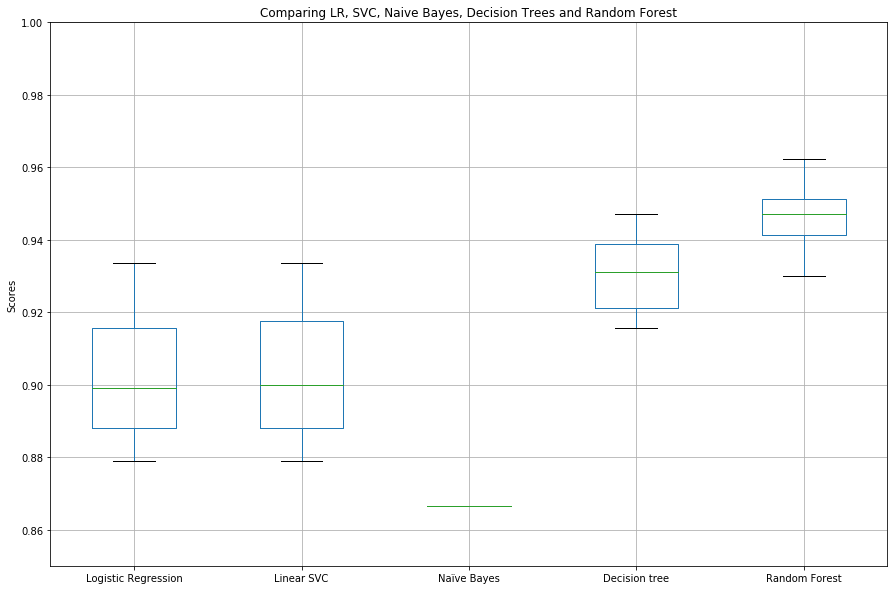

In [4]:
fit_eval(build_lda)

Use `components_` attribute of the LDA to find top 5 words of each topic and print them out.

In [5]:
X_train, _,_,_ = train_test_split(sms['text'], sms['label'], train_size=0.8, stratify=sms['label'], random_state=0) # The same as fit_eval  
lda, cv = build_lda(X_train)

for i, topic in enumerate(lda.components_, start=1):
    # Your solution
    top_five_indices = np.argsort(topic)[-5:][::-1]
    features = cv.get_feature_names()
    
    print('Top in '+str(i)+':', [features[i] for i in top_five_indices])

Top in 1: ['drive', 'point', 'account', 'show', 'expir']
Top in 2: ['time', 'night', 'im', 'home', 'go']
Top in 3: ['free', 'txt', 'ur', 'latest', 'phone']
Top in 4: ['dont', 'year', 'know', 'just', 'new']
Top in 5: ['lor', 'ok', 'wat', 'got', 'da']
Top in 6: ['pls', 'right', 'prize', 'won', 'send']
Top in 7: ['start', 'place', 'big', 'sent', 'told']
Top in 8: ['ok', 'contact', 'landlin', 'ya', 'video']
Top in 9: ['meet', 'work', 'tri', 'month', 'weekend']
Top in 10: ['week', 'ur', 'tone', 'free', 'nokia']
Top in 11: ['ill', 'sorri', 'later', 'im', 'yeah']
Top in 12: ['come', 'tonight', 'tomorrow', 'pick', 'finish']
Top in 13: ['ltgt', 'hi', 'oh', 'im', 'got']
Top in 14: ['today', 'your', 'birthday', 'class', 'late']
Top in 15: ['free', 'repli', 'text', 'nokia', 'txt']
Top in 16: ['know', 'leav', 'dear', 'ok', 'dont']
Top in 17: ['number', 'thank', 'mobil', 'claim', 'better']
Top in 18: ['stop', 'text', 'send', 'love', 'use']
Top in 19: ['wish', 'life', 'didnt', 'need', 'love']
Top in 

In a few sentences describe your observations with regard to comparing vanilla TF-IDF vs adding a LDA on top of a count vectorizer.

TF-IDF works better a bit better than LDA. This is because TF-IDF is better as it picks up the unique words which appear in spam. But LDA tries to group words in the spam. The grouping does not give us a good picture of spam, but the unique words in spam does help in detecting it.